In [1]:
from importlib import reload
import os
from time import time

import sys
sys.path.append('/homefs/home/wongfanc/density-ratio-estimation/')

import numpy as np
import scipy as sc
import pandas as pd
import random

import torch
print(torch.cuda.is_available())

import pprint
import editdistance

import utils
import tdre
import shifts
import viennarna_shifts as vshifts
import calibrate as cal

import flexs
import flexs.utils.sequence_utils as s_utils

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

True


2024-01-12 00:38:44.464899: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 00:38:44.464938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 00:38:44.466091: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 00:38:44.472978: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 00:38:46.116701: W tensorflow/comp

<IPython.core.display.Javascript object>

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(
    physical_devices[0], True
)

In [14]:
n = 10000
n_cal = 5000
avg_n_mut = 5


p_mut = avg_n_mut / 238
trainseqs_n = [vshifts.get_mutant(gfp_wt, p_mut, s_utils.AAS) for _ in range(n)]
print('Generating {} labeled training and calibration data...'.format(n))
t0 = time()
ytrain_n = gfp_landscape.get_fitness(trainseqs_n)
print('Done. ({} s)'.format(int(time() - t0)))

trainseqs_n, calseqs_n = trainseqs_n[: n - n_cal], trainseqs_n[n - n_cal :]
ytrain_n, ycal_n = ytrain_n[: n - n_cal], ytrain_n[n - n_cal :]

Generating 10000 labeled training and calibration data...
Done. (31 s)


In [19]:
model_class = flexs.baselines.models.MLP
model_kwargs = {
    'hidden_size': 512,
    'loss': 'MSE',
    'batch_size': 128,
}

print('Training...')
t0 = time()
model = flexs.Ensemble([
    model_class(len(trainseqs_n[0]), alphabet=s_utils.AAS, **model_kwargs)
    for i in range(3)
])
model.train(trainseqs_n, ytrain_n)
print('Done. ({} s)'.format(int(time() - t0)))

Training...
Done. (10 s)


40/40 [==============================] - 0s 1ms/step


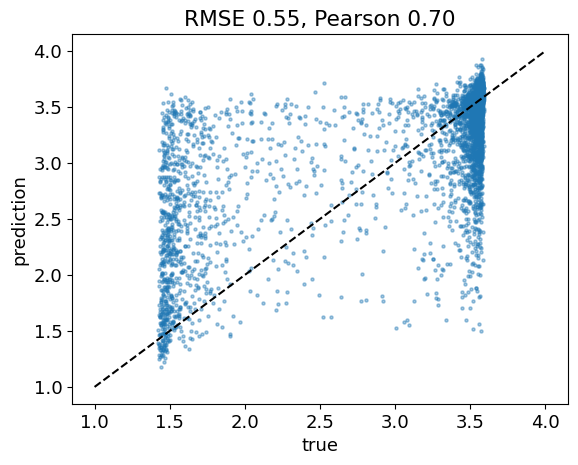

In [20]:
xy_lim = [1, 4]
predcal_n = model.get_fitness(calseqs_n)
rmse = np.sqrt(np.mean(np.square(predcal_n - ycal_n)))
r, p = sc.stats.pearsonr(predcal_n, ycal_n)
plt.scatter(ycal_n, predcal_n, alpha=0.4, s=5)
plt.xlabel('true'); plt.ylabel('prediction');
plt.plot(xy_lim, xy_lim, '--k');
plt.title('RMSE {:.2f}, Pearson {:.2f}'.format(rmse, r));

In [3]:
reload(vshifts)

landscape_name = 'gfp'
n = 10000
N = 5000
avg_n_mut = 5
noise_sd = 0

# model_class = flexs.baselines.models.LinearRegression
# model_kwargs = None

# model_class = flexs.baselines.models.RidgeCV
# model_kwargs = {
#     'alphas': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
#     'cv': 5
# }

model_class = flexs.baselines.models.CNN
model_kwargs = {
    'num_filters': 256,
    'hidden_size': 64,
    'loss': 'MSE',
    'batch_size': 128,
}
model = flexs.Ensemble([model_class(238, alphabet=s_utils.AAS, **model_kwargs) for i in range(3)])

explorer = 'adalead'
hp_name = 'threshold'
hp_vals = [0.1, 0.3, 0.5, 0.7, 0.9, 0.05, 0.01]
kwargs = {hp_name: hp_vals}

t0 = time()
flexsshift = vshifts.FLEXSShift(landscape_name, noise_sd=noise_sd)
trainseqs_n, ytrain_n, calseqs_n, ycal_n, predcal_n, testseqs_list, yseed = flexsshift.get_data(
    n,
    model_class,
    explorer,
    kwargs,
    model=model,
    model_kwargs=model_kwargs,
    n_cal=n - N,
    N=N,
    avg_n_mut=avg_n_mut,
    save_fname_prefix=None
)
print('{} sec'.format(int(time() - t0)))

2024-01-12 00:38:53.630326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:10:1c.0, compute capability: 8.0
/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Generating 10000 training and calibration data...
Done. (31 s)


2024-01-12 00:40:19.579938: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-12 00:40:19.685696: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-12 00:40:19.868522: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-12 00:40:21.081904: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f34699323d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-12 00:40:21.081928: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-01-12 00:40:21.087054: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705020021.180153   51289 device_compiler.h:

Regression model trained for threshold = 0.1
1/1 [==============================] - 0s 17ms/step


8/8 [==============================] - 0s 3ms/step
Designed sequences for threshold = 0.1
Regression model trained for threshold = 0.3
1/1 [==============================] - 0s 223ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


8/8 [==============================] - 0s 3ms/step
Designed sequences for threshold = 0.3
Regression model trained for threshold = 0.5
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


8/8 [==============================] - 0s 3ms/step
Designed sequences for threshold = 0.5
Regression model trained for threshold = 0.7
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


8/8 [==============================] - 0s 3ms/step
Designed sequences for threshold = 0.7
Regression model trained for threshold = 0.9
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


8/8 [==============================] - 0s 3ms/step
Designed sequences for threshold = 0.9
Regression model trained for threshold = 0.05
40/40 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


8/8 [==============================] - 0s 3ms/step
Designed sequences for threshold = 0.05
Regression model trained for threshold = 0.01
2/2 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


8/8 [==============================] - 0s 3ms/step
Designed sequences for threshold = 0.01
1810 sec


In [5]:
gfp_landscape = flexs.landscapes.BertGFPBrightness()
gfp_wt = gfp_landscape.gfp_wt_sequence

print(f'WT sequence: {gfp_wt}, fitness: {gfp_landscape.get_fitness([gfp_wt])}')

WT sequence: MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK, fitness: [3.57231593]


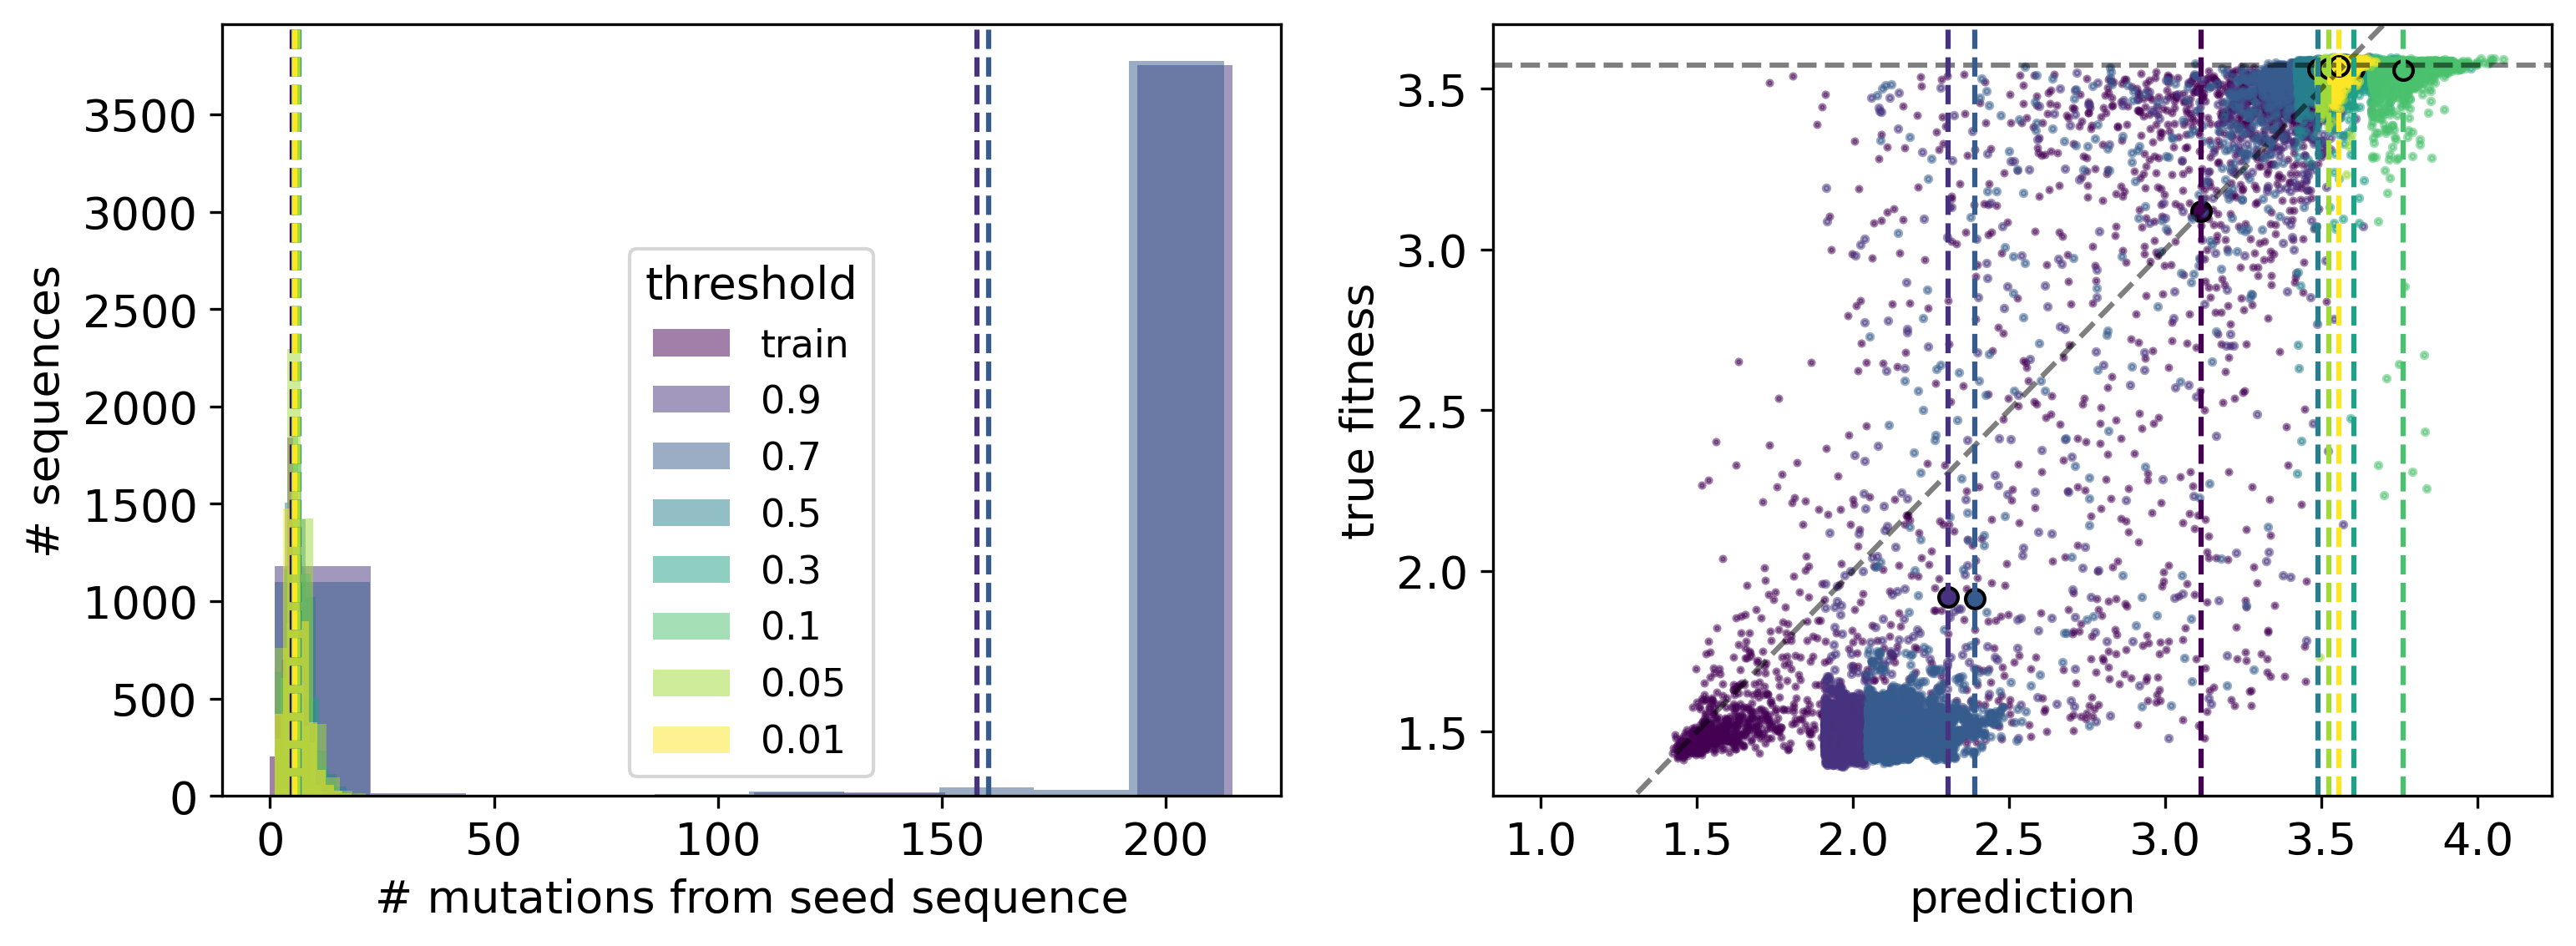

In [13]:
# pretty plot for presentations
scatter_y_lim = [1.3, 3.7]
diag_line_lim = [1, 4]
font = {'size' : 13}
matplotlib.rc('font', **font)
scatter_s = 3
cmap = matplotlib.colormaps['viridis']
disttrain_n = np.array([editdistance.eval(gfp_wt, s) for s in trainseqs_n])

plt.figure(figsize=(12, 4), dpi=300)

plt.subplot(121)
plt.hist(disttrain_n, alpha=0.5, label='train', color=cmap(0));
plt.axvline(np.mean(disttrain_n), alpha=1, linestyle='--', color=cmap(0))
plt.xlabel('# mutations from seed sequence');
plt.ylabel('# sequences');

plt.subplot(122)
plt.scatter(predcal_n, ycal_n, alpha=0.5, s=2, label='validation', color=cmap(0));
plt.scatter(np.mean(predcal_n), np.mean(ycal_n), color=cmap(0), alpha=1, s=30, edgecolor='k');
plt.plot(diag_line_lim, diag_line_lim, '--k', alpha=0.5);
plt.axhline(gfp_landscape.get_fitness([gfp_wt]), alpha=0.5, linestyle='--', color='k')
plt.axvline(np.mean(predcal_n), alpha=1, linestyle='--', color=cmap(0))

# plt.xlim(scatter_lim);
plt.ylim(scatter_y_lim);
plt.ylabel('true fitness');
plt.xlabel('prediction');

i_order = [4, 3, 2, 1, 0, 5, 6]

# for i, (testseqs_n, ytest_n, predtest_n) in enumerate(testseqs_list):
for i_idx, i in enumerate(i_order):
    testseqs_n, ytest_n, predtest_n = testseqs_list[i]
    color = cmap((i_idx + 1) / len(hp_vals))
    plt.subplot(121)
    disttest_n = np.array([editdistance.eval(gfp_wt, s) for s in testseqs_n])
    plt.hist(disttest_n, alpha=0.5, label=hp_vals[i], color=color);
    plt.axvline(np.mean(disttest_n), linestyle='--', color=color)

    plt.subplot(122)
    plt.scatter(predtest_n, ytest_n, alpha=0.5, s=scatter_s, color=color);
    plt.axvline(np.mean(predtest_n), alpha=1, linestyle='--', color=color);

    plt.scatter(np.mean(predtest_n), np.mean(ytest_n), color=color, alpha=1, s=30, edgecolor='k');

plt.subplot(121)
plt.legend(title=hp_name, fontsize=11);
